In [1]:
!git clone https://github.com/jqshang/CSC2541.git
%cd CSC2541

Cloning into 'CSC2541'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 128 (delta 40), reused 92 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 2.20 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/CSC2541


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset.syn_data import generate_synthetic_protein_data
from model.granger_nn import GrangerNeuralNet
from model.util import adjacency_to_digraph, plot_digraph
from train_granger_nn import train_granger_net

In [24]:
pairs = [("A1", "A16"), ("A16", "A17"), ("A17", "A30"), ("A30", "A36"), ("A30", "A16"), ("A36", "A50")]
num_acids = 50
num_steps = 200
positions, angles, amino_acids = generate_synthetic_protein_data(num_acids, num_steps, pairs, version="v3")

In [25]:
positions.min(), positions.max()

(np.float64(-26.944041030665076), np.float64(37.801210932375504))

In [26]:
angles.min(), angles.max()

(np.float64(-179.99800679673433), np.float64(179.98997305247366))

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/500 | MSE: 0.0015 | L1_v: 21.3951 | L1_t: 106.9851
Epoch 100/500 | MSE: 0.0000 | L1_v: 20.2683 | L1_t: 101.3583
Epoch 150/500 | MSE: 0.0000 | L1_v: 19.1423 | L1_t: 95.7323
Epoch 200/500 | MSE: 0.0000 | L1_v: 18.0166 | L1_t: 90.1067
Epoch 250/500 | MSE: 0.0000 | L1_v: 16.8911 | L1_t: 84.4812
Epoch 300/500 | MSE: 0.0000 | L1_v: 15.7657 | L1_t: 78.8559
Epoch 350/500 | MSE: 0.0000 | L1_v: 14.6404 | L1_t: 73.2306
Epoch 400/500 | MSE: 0.0000 | L1_v: 13.5152 | L1_t: 67.6055
Epoch 450/500 | MSE: 0.0000 | L1_v: 12.3901 | L1_t: 61.9804
Epoch 500/500 | MSE: 0.0000 | L1_v: 11.2650 | L1_t: 56.3554


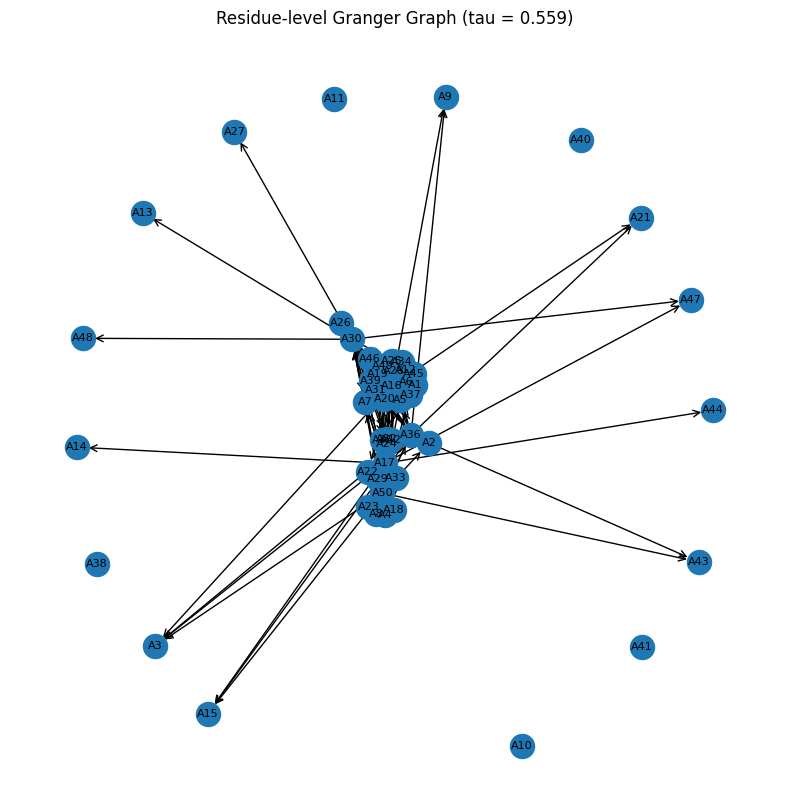

In [27]:
G_res_position, tau_position, S_res_position = train_granger_net(positions)
DG_res_position = adjacency_to_digraph(G_res_position,node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_position:.3f})"
plot_digraph(DG_res_position, node_names=amino_acids, title=plot_title)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/500 | MSE: 0.0025 | L1_v: 9.5075 | L1_t: 47.5475
Epoch 100/500 | MSE: 0.0000 | L1_v: 9.0049 | L1_t: 45.0449
Epoch 150/500 | MSE: 0.0000 | L1_v: 8.5034 | L1_t: 42.5434
Epoch 200/500 | MSE: 0.0000 | L1_v: 8.0024 | L1_t: 40.0423
Epoch 250/500 | MSE: 0.0000 | L1_v: 7.5016 | L1_t: 37.5415
Epoch 300/500 | MSE: 0.0000 | L1_v: 7.0010 | L1_t: 35.0410
Epoch 350/500 | MSE: 0.0000 | L1_v: 6.5006 | L1_t: 32.5405
Epoch 400/500 | MSE: 0.0000 | L1_v: 6.0002 | L1_t: 30.0402
Epoch 450/500 | MSE: 0.0000 | L1_v: 5.5000 | L1_t: 27.5399
Epoch 500/500 | MSE: 0.0000 | L1_v: 4.9998 | L1_t: 25.0398


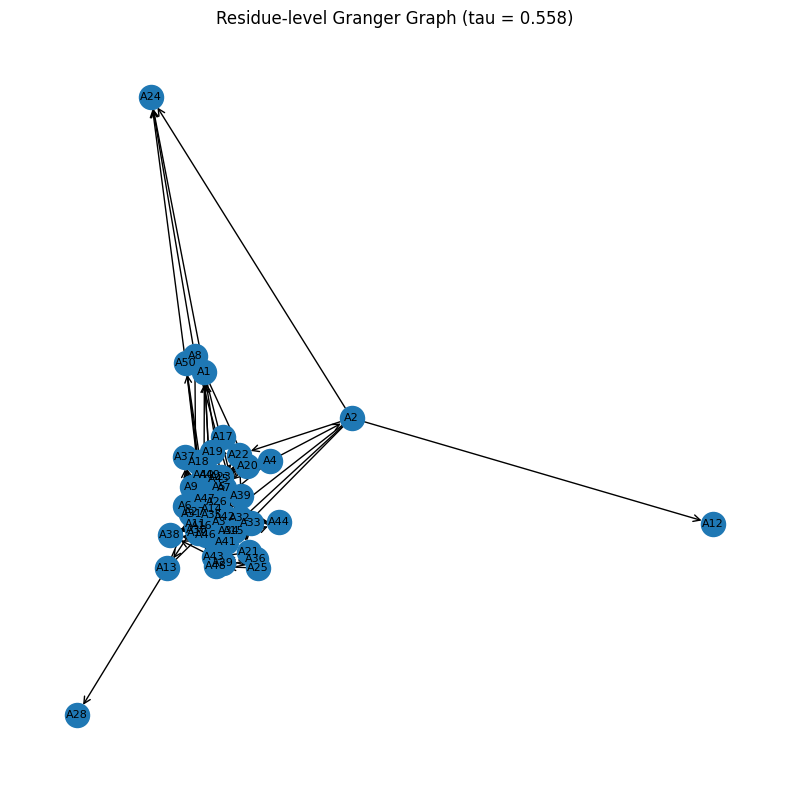

In [28]:
G_res_angle, tau_angle, S_res_angle = train_granger_net(angles)
DG_res_angle = adjacency_to_digraph(G_res_angle, node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_angle:.3f})"
plot_digraph(DG_res_angle, node_names=amino_acids, title=plot_title)

In [29]:

def normalize_scores(S):
    S = S.copy()
    max_val = S.max()
    if max_val <= 0:
        return S
    return S / max_val

S_pos_norm = normalize_scores(S_res_position)
S_ang_norm = normalize_scores(S_res_angle)

alpha = 0.5
beta = 0.5

S_res_comb = alpha * S_pos_norm + beta * S_ang_norm

percentile = 95
tau_comb = np.percentile(S_res_comb, percentile)
G_res_comb = (S_res_comb > tau_comb).astype(int)
np.fill_diagonal(G_res_comb, 0)

print("Combined threshold (tau_comb):", tau_comb)
print("Number of residue edges in combined graph:", G_res_comb.sum())

Combined threshold (tau_comb): 0.998979
Number of residue edges in combined graph: 123


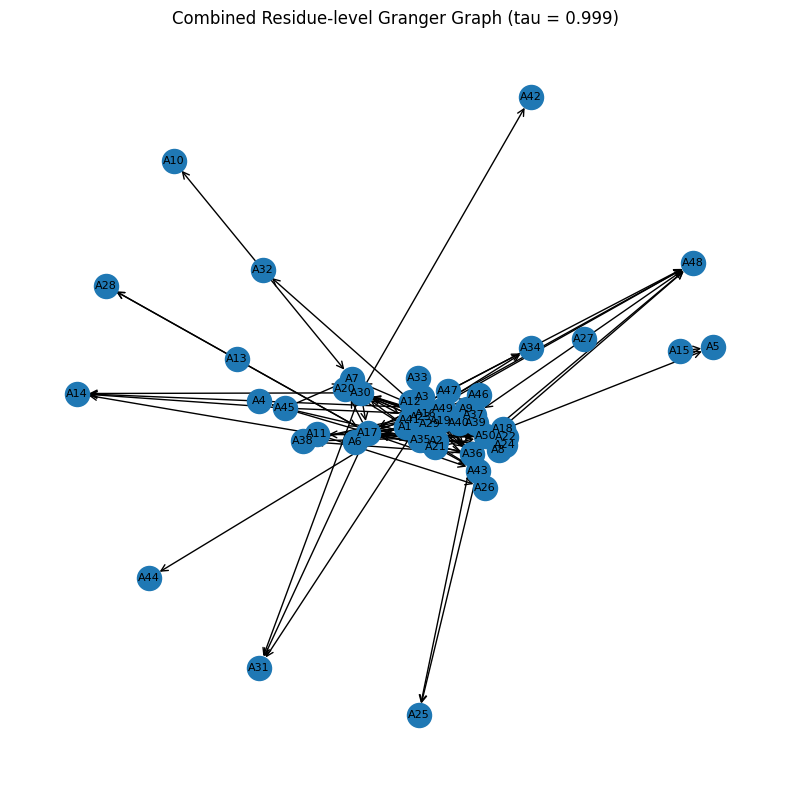

In [30]:
DG_res_comb = adjacency_to_digraph(G_res_comb, node_names=amino_acids)
plot_title = f"Combined Residue-level Granger Graph (tau = {tau_comb:.3f})"
plot_digraph(DG_res_comb, node_names=amino_acids, title=plot_title)

In [35]:
import networkx as nx

def dfs_all_simple_paths(DG, source, target, max_depth=None):
    """
    Depth-first search to find all simple directed paths from source to target.

    DG: networkx.DiGraph
    source, target: node ids in DG (e.g. integers 0..N-1)
    max_depth: optional int; if not None, cut off paths longer than this

    Yields:
        paths as lists of node ids [source, ..., target]
    """
    stack = [(source, [source])]

    while stack:
        (node, path) = stack.pop()

        # optional depth limit
        if max_depth is not None and len(path) > max_depth:
            continue

        for nbr in DG.successors(node):
            if nbr in path:
                # avoid cycles
                continue
            new_path = path + [nbr]
            if nbr == target:
                yield new_path
            else:
                stack.append((nbr, new_path))


In [36]:
def signaling_paths_allosteric_to_active(
    DG,
    amino_acids,
    allosteric_sites,
    active_site,
    max_depth=None
):
    """
    DG: residue-level DiGraph (nodes are ints 0..R-1)
    amino_acids: list of residue names, e.g. ["A1", ..., "A50"]
    allosteric_sites: list of residue names, e.g. ["A1", "A5"]
    active_site: single residue name, e.g. "A50"

    Returns:
      paths_by_source: dict {allosteric_name: [ [residue_names...], ... ]}
      signaling_subgraph: DiGraph containing only nodes/edges on these paths
    """
    # map names <-> indices
    name_to_idx = {name: i for i, name in enumerate(amino_acids)}

    target_idx = name_to_idx[active_site]
    allosteric_indices = [name_to_idx[name] for name in allosteric_sites]

    paths_by_source = {}
    used_nodes = set()
    used_edges = set()

    for allo_name, allo_idx in zip(allosteric_sites, allosteric_indices):
        paths_idx = list(dfs_all_simple_paths(DG, allo_idx, target_idx, max_depth))

        # convert to residue names
        paths_names = []
        for p in paths_idx:
            used_nodes.update(p)
            for u, v in zip(p, p[1:]):
                used_edges.add((u, v))

            paths_names.append([amino_acids[i] for i in p])

        paths_by_source[allo_name] = paths_names

    # build signaling subgraph containing only nodes/edges on found paths
    signaling_subgraph = DG.subgraph(used_nodes).copy()
    # remove any edges not in used_edges (in case DG had extras between these nodes)
    for u, v in list(signaling_subgraph.edges()):
        if (u, v) not in used_edges:
            signaling_subgraph.remove_edge(u, v)

    return paths_by_source, signaling_subgraph


In [48]:
# assuming plot_digraph(DG, node_names, title) is already defined

allosteric_sites = ["A1"]
active_site = "A50"

paths_by_source, DG_signal = signaling_paths_allosteric_to_active(
    DG_res_comb,      # or DG_res_position / DG_res_angle
    amino_acids,
    allosteric_sites,
    active_site,
    max_depth=None    # or e.g. 10 if you want to avoid super-long paths
)

# print("Signaling paths from allosteric sites to active site:")
# for src, paths in paths_by_source.items():
#     print(f"\nFrom {src} -> {active_site}:")
#     if not paths:
#         print("  (no path found)")
#     for p in paths:
#         print("  " + " -> ".join(p))

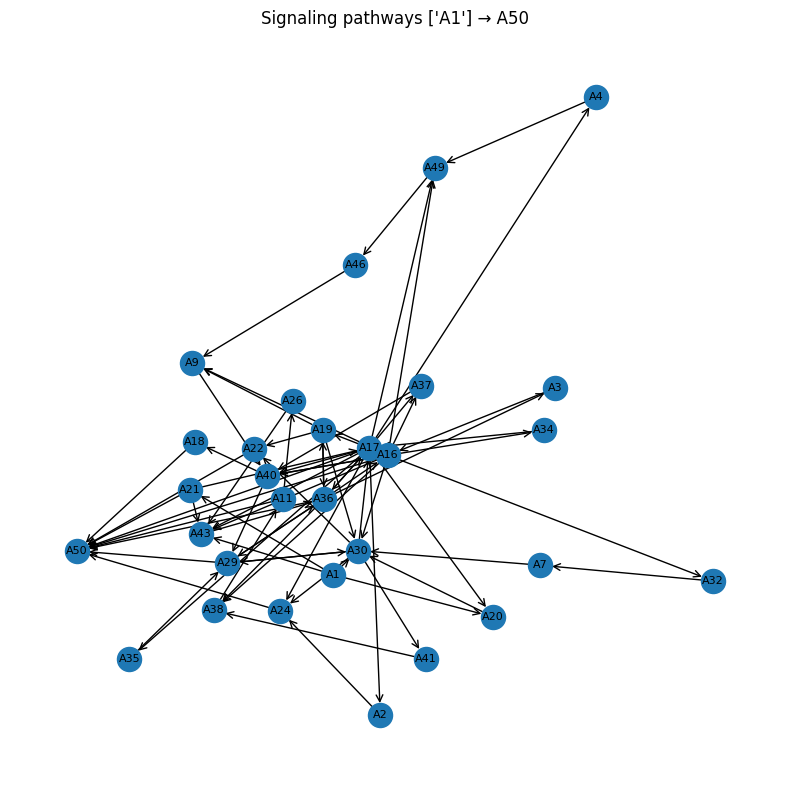

In [49]:
plot_title = f"Signaling pathways {allosteric_sites} → {active_site}"
plot_digraph(DG_signal, node_names=amino_acids, title=plot_title)

In [51]:
import networkx as nx

def build_scc_quotient_graph(DG, amino_acids):
    """
    DG: directed graph (e.g., DG_signal) whose nodes are ints (0..R-1)
    amino_acids: list of residue names, amino_acids[i] is name of node i

    Returns:
      sccs: list of sets of node indices (each set is one SCC)
      node_to_scc: dict mapping original node index -> scc_id
      Q: quotient DiGraph where each node is an SCC (id 0..K-1), edges between SCCs
         have attributes:
             - members_idx: list of residue indices
             - members_names: list of residue names
             - label: string label for plotting
    """
    # 1) strongly connected components
    sccs = list(nx.strongly_connected_components(DG))  # each is a set of node indices

    # 2) map each original node to a component id
    node_to_scc = {}
    for cid, comp in enumerate(sccs):
        for node in comp:
            node_to_scc[node] = cid

    # 3) build quotient graph Q
    Q = nx.DiGraph()

    # add SCC nodes with attributes
    for cid, comp in enumerate(sccs):
        members_idx = sorted(list(comp))
        members_names = [amino_acids[i] for i in members_idx]
        label = ",".join(members_names)  # compact label for plotting

        Q.add_node(
            cid,
            members_idx=members_idx,
            members_names=members_names,
            label=label,
        )

    # add edges between SCCs
    for u, v in DG.edges():
        cu = node_to_scc[u]
        cv = node_to_scc[v]
        if cu != cv:
            Q.add_edge(cu, cv)

    return sccs, node_to_scc, Q


In [52]:
def print_sccs(sccs, amino_acids):
    """
    Pretty-print SCCs in terms of residue names.
    """
    print("Strongly connected components (SCCs):")
    for cid, comp in enumerate(sccs):
        members_idx = sorted(list(comp))
        members_names = [amino_acids[i] for i in members_idx]
        print(f"  SCC {cid}: " + ", ".join(members_names))


In [53]:
import matplotlib.pyplot as plt

def plot_digraph_labels(DG, title=None, figsize=(8, 6)):
    """
    DG: DiGraph whose nodes have a 'label' attribute (string).
    """
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(DG, k=0.5, iterations=200)

    labels = {n: DG.nodes[n].get("label", str(n)) for n in DG.nodes()}

    nx.draw_networkx_nodes(DG, pos, node_size=400)
    nx.draw_networkx_edges(DG, pos, arrows=True, arrowstyle="->", arrowsize=12)
    nx.draw_networkx_labels(DG, pos, labels, font_size=8)

    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()


Strongly connected components (SCCs):
  SCC 0: A50
  SCC 1: A24
  SCC 2: A2
  SCC 3: A22
  SCC 4: A18
  SCC 5: A3, A4, A7, A9, A11, A16, A17, A19, A20, A26, A29, A30, A32, A34, A35, A36, A37, A38, A40, A41, A43, A46, A49
  SCC 6: A21
  SCC 7: A1


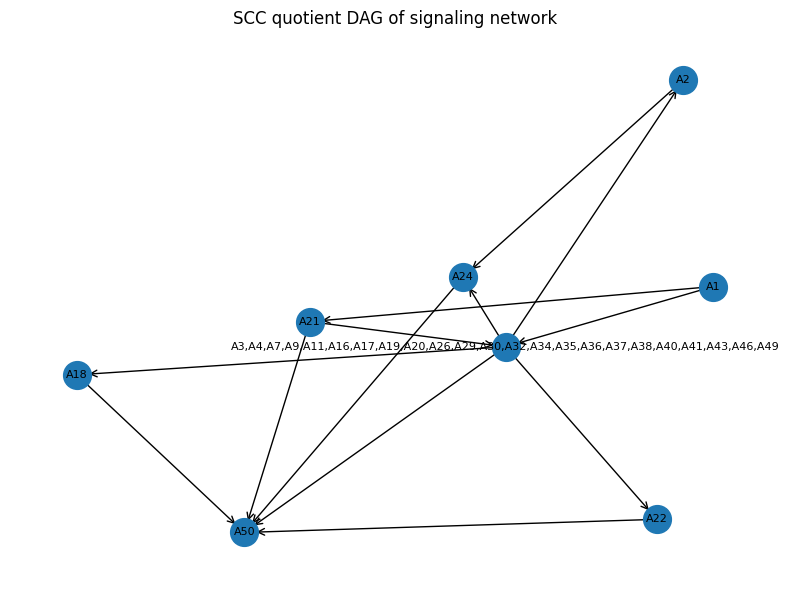

In [54]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph_labels(Q, title=plot_title)

In [55]:
def dfs_all_simple_paths(DG, source, target, max_depth=None):
    """
    Same DFS as before, but now used on the SCC-level DAG.

    DG: DiGraph
    source, target: node ids in DG
    max_depth: optional path length cut-off
    """
    stack = [(source, [source])]

    while stack:
        node, path = stack.pop()

        if max_depth is not None and len(path) > max_depth:
            continue

        for nbr in DG.successors(node):
            if nbr in path:
                continue
            new_path = path + [nbr]
            if nbr == target:
                yield new_path
            else:
                stack.append((nbr, new_path))


def scc_paths_allosteric_to_active(
    Q, node_to_scc, amino_acids, allosteric_sites, active_site
):
    """
    Q: SCC-level DAG
    node_to_scc: mapping original residue index -> SCC id
    amino_acids: list of residue names
    allosteric_sites: list of residue names
    active_site: residue name

    Prints SCC-level paths and returns them as list of lists of SCC ids.
    """
    name_to_idx = {name: i for i, name in enumerate(amino_acids)}

    active_idx = name_to_idx[active_site]
    active_scc = node_to_scc[active_idx]

    all_paths = {}

    for allo_name in allosteric_sites:
        allo_idx = name_to_idx[allo_name]
        allo_scc = node_to_scc[allo_idx]

        scc_paths = list(dfs_all_simple_paths(Q, allo_scc, active_scc))
        all_paths[allo_name] = scc_paths

        print(f"\nSCC-level paths from {allo_name} -> {active_site}:")
        if not scc_paths:
            print("  (no path)")
            continue

        for p in scc_paths:
            # p: list of SCC ids
            # turn into something readable: show SCC labels
            labels = [Q.nodes[cid]["label"] for cid in p]
            print("  " + "  ==>  ".join(labels))

    return all_paths


In [56]:
allosteric_sites = ["A1"]
active_site = "A50"

scc_paths = scc_paths_allosteric_to_active(
    Q, node_to_scc, amino_acids, allosteric_sites, active_site
)



SCC-level paths from A1 -> A50:
  A1  ==>  A21  ==>  A50
  A1  ==>  A21  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A50
  A1  ==>  A21  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A18  ==>  A50
  A1  ==>  A21  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A22  ==>  A50
  A1  ==>  A21  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A24  ==>  A50
  A1  ==>  A21  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A2  ==>  A24  ==>  A50
  A1  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A50
  A1  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36,A37,A38,A40,A41,A43,A46,A49  ==>  A18  ==>  A50
  A1  ==>  A3,A4,A7,A9,A11,A16,A17,A19,A20,A26,A29,A30,A32,A34,A35,A36